In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
%matplotlib inline

### Load Datasets

In [162]:
# labeled data
D_s = pd.read_csv('D_s_SCD1.csv')
D_s.head()

,SMILES,activity
0,O=C(O)c1ccc(N2CCC(Oc3ccccc3C(F)(F)F)CC2)nn1,0
1,O=C(NCC1CC1)c1ccc(N2CCN(C(=O)c3ccccc3C(F)(F)F)...,0
2,O=C(O)c1cncc(-c2ccc(N3CCC(Oc4ccccc4C(F)(F)F)CC...,0
3,O=C(O)CCCCCc1nc(-c2cn(Cc3cc(Br)c(Br)c(Br)c3)nn...,0
4,Cc1ccc(C(=O)Nc2ncc(Cc3cccc(C(F)(F)F)c3)s2)cc1C,0


### Molecules as Strings: SMILES notation
Simplified Molecular-Input Line-Entry System (SMILES) is a string representation of a molecule.<br>
RDKIT is a cheminformatics package with numerous modules for working with chemical data.

In [163]:
smi = "O=C(O)c1ccc(N2CCC(Oc3ccccc3C(F)(F)F)CC2)nn1"

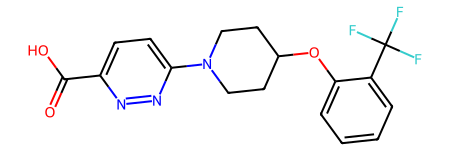

In [164]:
mol_from_smi = Chem.MolFromSmiles(smi)
mol_from_smi

In [165]:
D_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    642 non-null    object
 1   activity  642 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ KB


In [166]:
smi_from_mol = Chem.MolToSmiles(mol_from_smi)
smi_from_mol

'O=C(O)c1ccc(N2CCC(Oc3ccccc3C(F)(F)F)CC2)nn1'

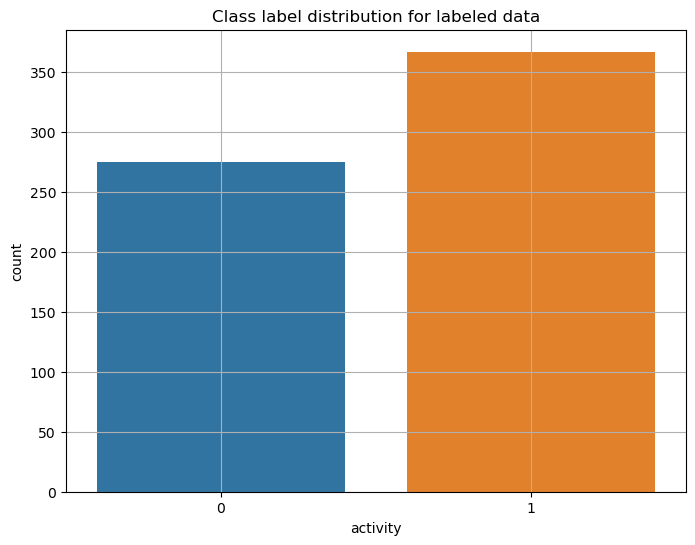

In [167]:
plt.figure(figsize = (8, 6))
plt.title(f'Class label distribution for labeled data')
plt.ylabel('No. of datapoints')
plt.xlabel('activity')
sns.countplot(x = D_s['activity'])
plt.grid()

In [168]:
# unlabeled data
D_u = pd.read_csv('D_u_SCD1.csv')
D_u.head()

,SMILES
0,CC1(C)Cc2c(C#N)c(OCC(=O)c3ccccc3)nc(-c3ccoc3)c...
1,CC(Sc1ncnc2sc(-c3ccccc3)cc12)C(=O)NCC1CCCO1
2,CCC1C(=O)NCCN1C(=O)c1ccc2nc(Cc3cccc(Cl)c3)oc2c1
3,O=C(c1ccco1)N1CCCC(c2nc(=O)c3nnn(Cc4c(Cl)cccc4...
4,CN(CC=Cc1ccc(Cl)cc1)Cc1cccc2ccccc12


In [169]:
D_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851726 entries, 0 to 851725
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  851726 non-null  object
dtypes: object(1)
memory usage: 6.5+ MB


In [170]:
# randomly pick datapoints to generate the same size dataset as D_s
indices = np.random.randint(low = 0, high = D_u.count()[0], size = (D_s.count()[0],))

In [171]:
D_u = D_u.iloc[indices].copy()
D_u.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 556681 to 547545
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  642 non-null    object
dtypes: object(1)
memory usage: 10.0+ KB


In [172]:
D_u.reset_index(drop = True, inplace = True)
D_u.head()

,SMILES
0,Cc1cc(S(=O)(=O)C2CC2)cc(=O)n1C(CC1CCCCO1)C(=O)...
1,COc1cc2nncc(-c3ccc(N)nc3)c2cc1OC
2,O=C(NCCN1CCC(n2c(=O)[nH]c3ccccc32)CC1)c1ccc[nH]1
3,CCOC(=O)c1ccc(NC(=O)CN(c2cccc(F)c2)S(C)(=O)=O)cc1
4,CCCNc1ncnc2c1cnn2C1OC(CO)C(O)C1O


### Generating Molecular Fingerprints
RDKIT offers 3 different ways to convert SMILES notation into vectors through a special types of molecular embedding methods. These vectors are commonly known as fingerprints: <br>

1. Topological fingerprints: These are rule-based path subtype fingerprints where each dimension represents a specific chemical structure. Embedding space size = 1024. <br>

2. Morgan fingerprints: These are rule-based circular subtype fingerprints where each dimension represents a specific chemical structure which is based on neighboring atoms upto a certain radius. Embedding space size = 300 to 1024. <br>

3. MACCS keys: These are structure based fingerprints where each dimension represents a specific structure/functional group defined by 166 public MACCS keys. Embedding space size = 166. <br>

More information regarding molecualr fingerprints can be found at: https://academic.oup.com/bib/article/22/6/bbab291/6353238

In [173]:
# create dictionary to reference index to fingerprint type
fingerprint_name = {0: 'Topological fingerprints',
                    1: 'Morgan fingerprints',
                    2: 'Atompair fingerprints',
                    3: 'Topological Torsion fingerprints'}

def get_fp_arr(fp):
    array = np.zeros((0,), dtype = bool)
    DataStructs.ConvertToNumpyArray(fp, array)
    return array

def get_topological_fp(mol):
    fpgen = AllChem.GetRDKitFPGenerator(maxPath=3, fpSize=1024)
    return get_fp_arr(fpgen.GetFingerprint(mol))    

def get_morgan_fp(mol):
    fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=300)
    return get_fp_arr(fpgen.GetFingerprint(mol))

def get_atompair_fp(mol):
    fpgen = AllChem.GetAtomPairGenerator(countSimulation=False, fpSize=1024)
    return get_fp_arr(fpgen.GetFingerprint(mol))

def get_toptorsion_fp(mol):
    fpgen = AllChem.GetTopologicalTorsionGenerator(countSimulation=False, fpSize=1024)
    return get_fp_arr(fpgen.GetFingerprint(mol))


# takes a series of smiles and returns a list containing
# 4 different dataframes for 4 different fingerprints
def get_fingerprints(smiles_ser):
    fp_list = []

    # convert series to list
    smiles_list = smiles_ser.tolist()

    # convert smiles to mols
    mols_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]

    # get topological fingerprints
    top_list = [get_topological_fp(mol) for mol in mols_list]
    top_df = pd.DataFrame(np.array(top_list, dtype=bool))
    fp_list.append(top_df)

    # get morgan fingerprints
    mor_list = [get_morgan_fp(mol) for mol in mols_list]
    mor_df = pd.DataFrame(np.array(mor_list, dtype=bool))
    fp_list.append(mor_df)

    # atompair fingerprints
    ap_list = [get_atompair_fp(mol) for mol in mols_list]
    ap_df = pd.DataFrame(np.array(ap_list, dtype=bool))
    fp_list.append(ap_df)

    # topological torsion
    tor_list = [get_toptorsion_fp(mol) for mol in mols_list]
    tor_df = pd.DataFrame(np.array(tor_list, dtype=bool))
    fp_list.append(tor_df)

    return fp_list


#### Train/Test split on labeled data

In [174]:
from sklearn.model_selection import train_test_split

In [175]:
X_train, X_test, y_train, y_test = train_test_split(D_s['SMILES'], D_s['activity'],
                                                    test_size=0.25, stratify = D_s['activity'])

#### Get fingerprints for training, test and unlabeled data

In [197]:
X_train_fps_s = get_fingerprints(X_train)
X_test_fps = get_fingerprints(X_test)
X_train_fps_u = get_fingerprints(D_u['SMILES'])
y_train_all_views = [y_train, y_train, y_train, y_train]

#### Helper functions

In [177]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [3]:
def get_best_params():
    # random gird will be for hyperparameter tuning
    random_grid = {
        'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        'weights':['uniform','distance'],
        'metric':['jaccard', 'dice']
    }

    # cross validation to find good hyperparameters
    cv_params = []
    knn_c = KNeighborsClassifier()
    for i, X_train_fp in enumerate(X_train_fps_s):
        knn_cv = RandomizedSearchCV(estimator = knn_c, param_distributions = random_grid, n_iter = 35, verbose = 1)
        knn_cv.fit(X_train_fp, y_train)
        print(f'{knn_cv.best_params_}\n')
        cv_params.append(knn_cv.best_params_)
        
    return cv_params


# trains the model on labeled data
def train_models(cv_params): 
    # fit final models
    final_models = []
    for i, params in enumerate(cv_params):
        knn_final = KNeighborsClassifier(**params)
        knn_final.fit(X_train_fps_s[i], y_train)
        final_models.append(knn_final)
        
    return final_models


# gets indices and prediction for 'n' most confident predictions in each view
def get_best_n_prediction_indices(knn_models, n):
    
    # initialize list to store most confident indices and labels for each view
    indices_list = []
    labels_list = []

    for i, val in enumerate(knn_models):
        
        # get number of samples in unlabeled data
        n_samples = X_train_fps_u[i].shape[0]
        
        # get predictions and prediction probability
        y_pred_u = knn_models[i].predict(X_train_fps_u[i])
        y_pred_prob_u = knn_models[i].predict_proba((X_train_fps_u[i]))[np.arange(0, n_samples), y_pred_u]
        
        # get indices and labels of datapoints with most confident predictions
        max_prob_indices = np.argsort(y_pred_prob_u)[::-1][:n] 
        max_prob_labels = y_pred_u[max_prob_indices]

        indices_list.append(max_prob_indices)
        labels_list.append(max_prob_labels)
        
    return indices_list, labels_list


# returns min of the total number of unlabeled samples remaining in each view
def get_min_unlabeled_data_count():
    samples_count_list = [df.count()[0] for df in X_train_fps_u]
    return min(samples_count_list)
    
    
# given a list of indices and predicted labels for each view from the unlabeled data
# adds datapoints to the training data
# predcitions made by one model in a single view are added to training data in all other views
def add_unlabeled_data(indices_list, labels_list):
    for i in range(len(indices_list)):
        # make copy
        indices_to_use = indices_list.copy()
        labels_to_use = labels_list.copy()

        # remove ith indices list and labels list
        indices_to_use.pop(i)
        labels_to_use.pop(i)

        # create a single array
        indices_arr = (np.array(indices_to_use)).flatten()
        labels_arr = (np.array(labels_to_use)).flatten()

        # create dataframe to concatenate
        smiles_ser = (X_train_fps_u[i].iloc[indices_arr]).reset_index(drop=True)
        labels_ser = pd.Series(labels_arr, name='acitvity')
        df_to_add = pd.concat([smiles_ser, labels_ser], axis=1)

        # drop duplicates and reset index
        df_to_add.drop_duplicates(subset=df_to_add.columns[:-1], inplace=True)
        df_to_add.reset_index(inplace=True, drop=True)

        # concatenate to labeled data and reset indices
        X_train_fps_s[i] = pd.concat([X_train_fps_s[i], df_to_add[df_to_add.columns[:-1]]], axis=0)
        X_train_fps_s[i].reset_index(inplace=True, drop=True)

        y_train_all_views[i] = pd.concat([y_train_all_views[i], df_to_add['acitvity']])
        y_train_all_views[i].reset_index(inplace=True, drop=True)

        # remove added data from unlabeled df
        X_train_fps_u[i].drop(index=indices_arr, axis=0, inplace=True)


def get_combined_test_accuracy(models_list):
    n_test_samples = y_test.shape[0]
    y_pred_values = np.zeros((n_test_samples, len(models_list)), dtype=int)
    y_pred_final = np.zeros(n_test_samples)

    # get predictions for each model
    for i, model in enumerate(models_list):
        y_pred_values[:, i] = model.predict(X_test_fps[i])

    # most frequent prediction is the final prediction
    for i in range(n_test_samples):
        # predictions for a single sample by all 4 models
        y_preds_i = y_pred_values[i, :]

        # get counts for all labels
        values, counts = np.unique(y_preds_i, return_counts=True)

        # index of label with the highest counts
        mode_idx = np.argmax(counts)

        y_pred_final[i] = values[mode_idx]

    # get accuracy
    acc = accuracy_score(y_test, y_pred_final)
    f1 = f1_score(y_test, y_pred_final)

    return acc, f1


# prints test accuracy values given predictions and true value
def print_individual_test_accuracies(models_list):
    
    # get prediction and accuracy for each model
    for i, model in enumerate(models_list):
        y_pred = model.predict(X_test_fps[i])
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f'Accuracy for model trained on {fingerprint_name[i]} is {acc:0.3f} and f1-score is {f1:0.3f}.\n')        

### Test Accuracy with Supervised Learning (KNN)
For this part, 4 separate models will be trained using 4 different fingerprints and test accuracy will be obtained.

In [179]:
# train models for each view on the labeled data
model_params = get_best_params()
sup_models = train_models(model_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'weights': 'distance', 'n_neighbors': 10, 'metric': 'dice'}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'dice'}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'jaccard'}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'jaccard'}



In [180]:
# get test accuracy
print_individual_test_accuracies(sup_models)

Accuracy for model trained on Topological fingerprints is 0.733 and f1-score is 0.784.

Accuracy for model trained on Morgan fingerprints is 0.727 and f1-score is 0.780.

Accuracy for model trained on Atompair fingerprints is 0.739 and f1-score is 0.792.

Accuracy for model trained on Topological Torsion fingerprints is 0.708 and f1-score is 0.759.



### Semi-supervised multiview training using unlabeled data
1. Models will be trained on labeled data and used to make predictions on unlabeled data.
2. 10 of the most confident predictions for each view and their labels will be added to labeled data in other views.
3. Models will be retained on the updated labeled dataset and steps will be repeated until there is no unlabeled data left.

In [201]:
# runs multiview training using 'n_values' from the unlabeled data each iteration
def multi_view_training(n_values):
    
    # initialize list to store combined test acc
    # combined training acc not calculated as training data is not the same for different views
    test_acc = []
    test_f1 = []
    
    # run loop as long as there's enough unlabeled data
    while get_min_unlabeled_data_count() >= n_values:
        
        # train model and get test accuracy scores
        models_list = train_models(model_params)
        acc, f1_sc = get_combined_test_accuracy(model_params)
        test_acc.append(acc)
        test_f1.append(f1_sc)
        
        # get prediction on unlabeled data and add 'n' most confident datapoints to labeled data
        indices_list, labels_list = get_best_n_prediction_indices(models_list)
        add_unlabeled_data(indices_list, labels_list)
        
    return models_list, test_acc, test_f1    